# PySDD: SDD Python Wrapper

*Wannes Meert (KU Leuven), Arthur Choi (UCLA) - 2019*

In [7]:
import os, sys
sys.path.append(os.pardir)

In [8]:
import pysdd
from pysdd.sdd import Vtree, SddManager, WmcManager, Fnf

In [10]:
from array import array
from pathlib import Path
from graphviz import Source
import math

## Vtree

In [11]:
vtree = Vtree(4)

In [12]:
print("variable count: {}".format(vtree.var_count()))

variable count: 4


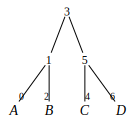

In [13]:
Source(vtree.dot())

## SDD Manager

Ask for documentation:

In [14]:
SddManager?

Init signature: SddManager(self, /, *args, **kwargs)
Docstring:     
SddManager(long var_count=1, bool auto_gc_and_minimize=False, Vtree vtree=None)
Creates a new SDD manager, either given a vtree or using a balanced vtree over the given number of variables.

    :param var_count: Number of variables
    :param auto_gc_and_minimize: Automatic garbage collection
        Automatic garbage collection and automatic SDD minimization are activated in the created manager when
        auto gc and minimize is not 0.
    :param vtree: The manager copies the input vtree. Any manipulations performed by
        the manager are done on its own copy, and does not affect the input vtree.

    The creation and manipulation of SDDs are maintained by an SDD manager.
    The use of an SDD manager is analogous to the use of managers in OBDD packages
    such as CUDD [10]. For a discussion on the design and implementation of such
    systems, see [7].

    To declare an SDD manager, one provides an initial 

Create new manager with four variables A, B, C, and D. The variables can be requested using the `literal` function or the `var` property:

In [15]:
mgr = SddManager(var_count=4)
a = mgr.literal(1)
b, c, d = mgr.vars[2:5]
a

SddNode(name=1,id=3)

A negative literal can be obtained by negating a positive literal or negating the numeric representation of a literal.

In [16]:
str(-mgr.literal(1)), str(mgr.literal(-1))

('SddNode(name=-1,id=4)', 'SddNode(name=-1,id=4)')

Most methods that require a literal accept either integer numbers or sdd nodes objects to methods:

In [17]:
mgr.is_var_used(-2)

0

In [18]:
mgr.is_var_used(-b)

0

Create the formula $(A \land B) \lor (C \land D)$

In [19]:
fab   = mgr.conjoin(a, b)
fcd   = mgr.conjoin(c, d)
fabcd = mgr.disjoin(fab, fcd)
str(fcd)

'SddNode(name=Decision,id=12)'

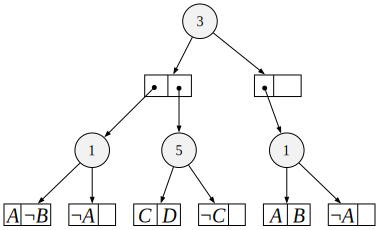

In [20]:
Source(fabcd.dot())

Use shorter syntax by mapping `&`/`|` to `*`/`+`:

In [21]:
mgr = SddManager(var_count=4)
a, b, c, d = mgr.vars

 node size      : 2
 sdd size       : 8
 sdd node count : 4


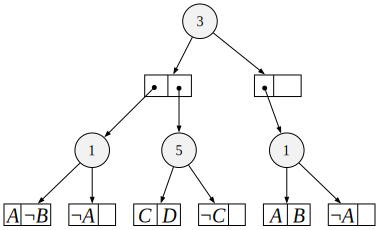

In [22]:
fabcd = (a & b) | (c & d)
print(f" node size      : {fabcd.node_size()}")
print(f" sdd size       : {fabcd.size()}")
print(f" sdd node count : {fabcd.count()}")
Source(fabcd.dot())

Which can be minimized using:

In [23]:
fabcd.ref()
mgr.minimize_limited()
print(f" node size      : {fabcd.node_size()}")
print(f" sdd size       : {fabcd.size()}")
print(f" sdd node count : {fabcd.count()}")
Source(fabcd.dot())
fabcd.deref()

 node size      : 2
 sdd size       : 6
 sdd node count : 3


Or we can minimize cardinality

 node size      : 2
 sdd size       : 10
 sdd node count : 5


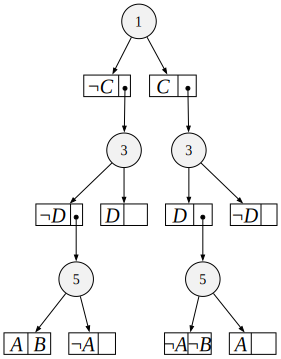

In [24]:
fabcd = mgr.global_minimize_cardinality(fabcd)
print(f" node size      : {fabcd.node_size()}")
print(f" sdd size       : {fabcd.size()}")
print(f" sdd node count : {fabcd.count()}")
Source(fabcd.dot())

## Examples

### Example: API documentation example 1

In [25]:
var_count = 4
var_order = array("l", [2,1,4,3])
tree_type = "balanced"

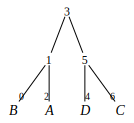

In [26]:
vtree = Vtree(var_count=var_count, var_order=var_order, vtree_type=tree_type)
Source(vtree.dot())

In [27]:
mgr = SddManager(vtree=vtree)

construct a formula $(A \land B) \lor (B \land C) \lor (C \land D)$

In [28]:
f_a, f_b, f_c, f_d = mgr.vars

In [29]:
str(f_a)

'SddNode(name=1,id=5)'

In [30]:
alpha = mgr.false()

In [31]:
beta  = f_a & f_b
alpha = alpha | beta
beta  = f_b & f_c

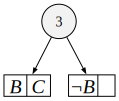

In [32]:
Source(mgr.dot(beta))

In [33]:
alpha = alpha | beta
beta  = f_c & f_d
alpha = alpha | beta

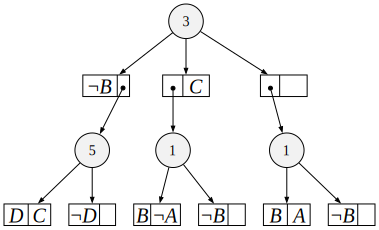

In [34]:
Source(alpha.dot())

### Example: Load from CNF file

In [35]:
cnf_str = """p cnf 6 3
1 4 0
-1 2 5 0
-1 -2 3 6 0
"""
mgr, f = SddManager.from_cnf_string(cnf_str)

Read CNF: vars=6 clauses=3


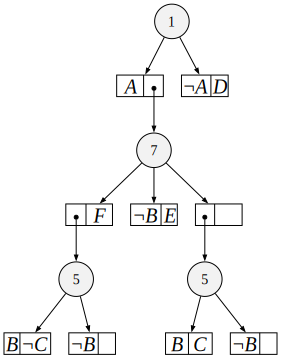

In [36]:
Source(f.dot())

#### Change the SDD after loading the CNF

In [37]:
print(f"Var count before: {mgr.var_count()}")
mgr.add_var_after_last()
mgr.add_var_after_last()
print(f"Var count after:  {mgr.var_count()}")

Var count before: 6
Var count after:  8


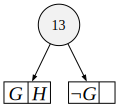

In [38]:
g = mgr.literal(7)
h = mgr.literal(8)

fp = g & h
Source(fp.dot())

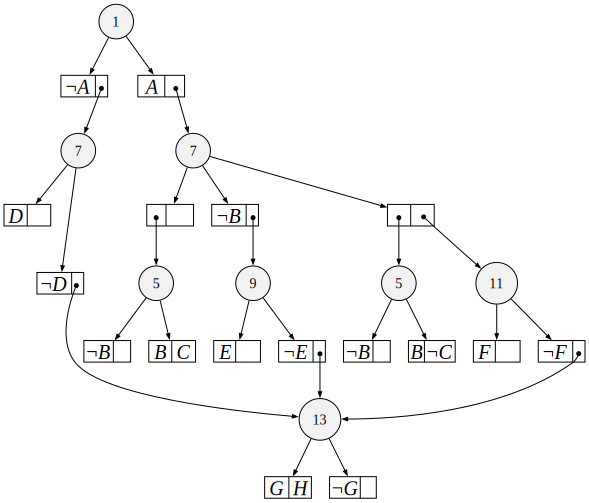

In [39]:
fpp = f | fp
Source(fpp.dot())

### Example: API documentation example 6

In [40]:
vtree_path = Path("../examples/input/opt-swap.vtree")
if not vtree_path.exists():
    print(f"File not found: {vtree_path}")
sdd_path = Path("../examples/input/opt-swap.sdd")
if not sdd_path.exists():
    print(f"File not found: {sdd_path}")

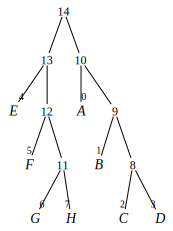

In [41]:
vtree = Vtree(filename=bytes(vtree_path))    
Source(vtree.dot())

In [42]:
mgr = SddManager.from_vtree(vtree)
alpha = mgr.read_sdd_file(bytes(sdd_path))
print(f"Size alpha: {alpha.size()}")

Size alpha: 116


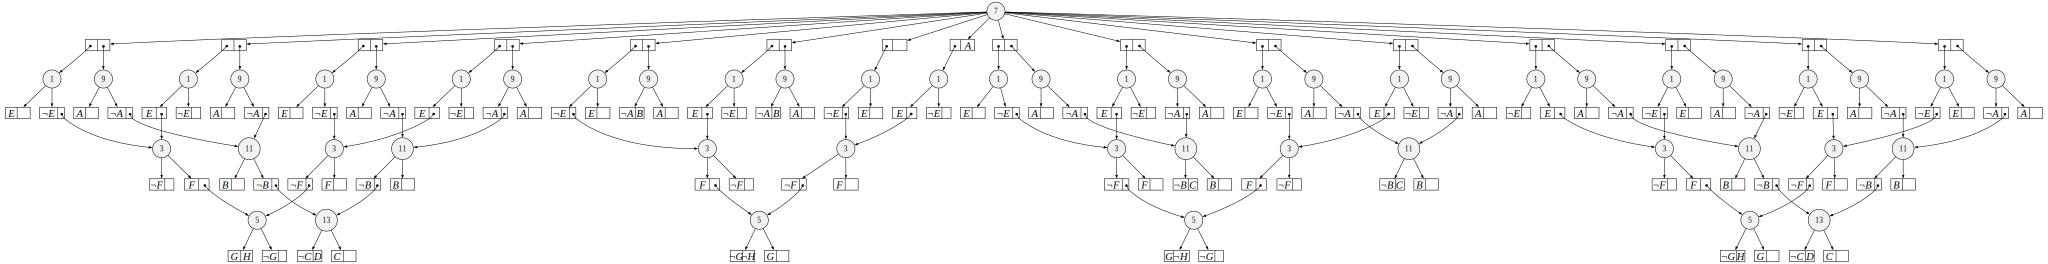

In [43]:
Source(alpha.dot())

In [44]:
alpha.ref()

Minimize the SDD

In [45]:
mgr.minimize()
print(f"Size alpha: {alpha.size()}")

Size alpha: 8


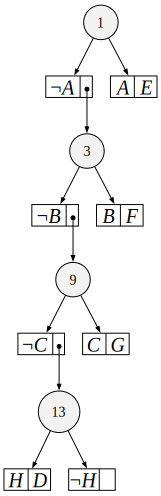

In [46]:
Source(alpha.dot())

Show the new vtree after minimization.

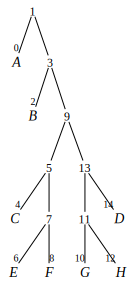

In [47]:
new_vtree = mgr.vtree()
Source(new_vtree.dot())

Augment the SDD

In [48]:
beta = alpha * (mgr.literal(4) + mgr.literal(5))
print(f"Size beta: {beta.size()}")

Size beta: 22


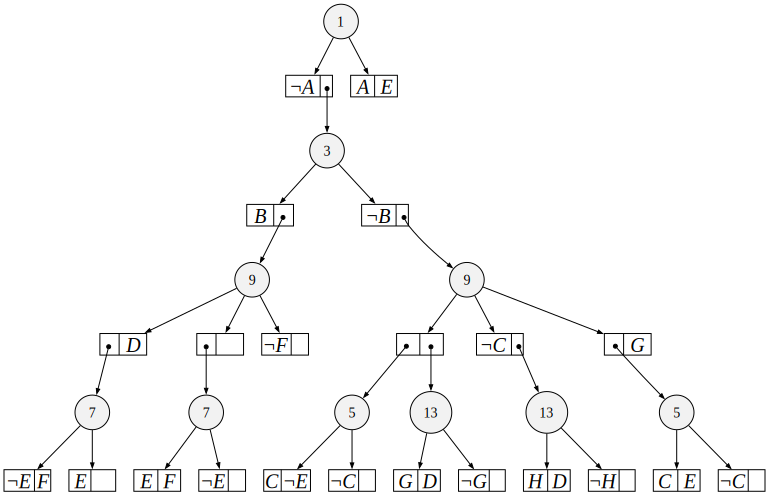

In [49]:
Source(beta.dot())

Perform minimization again on new SDD

In [50]:
beta.ref()

In [51]:
mgr.minimize()
print(f"Size: {beta.size()}")

Size: 21


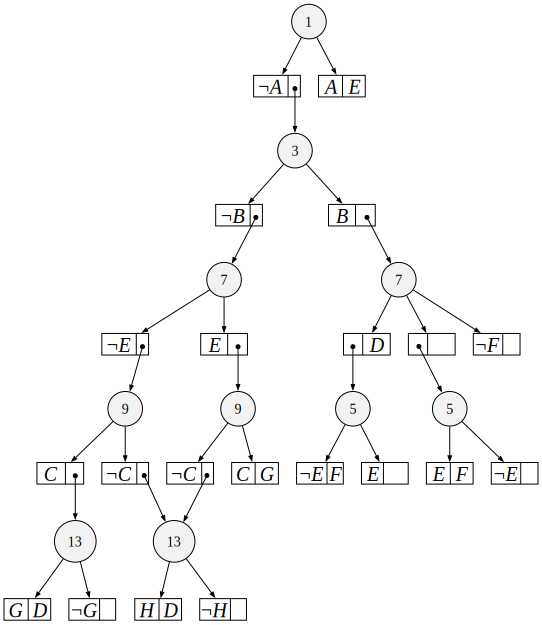

In [52]:
Source(beta.dot())

In [53]:
beta.deref()

### Example: WMC

In [54]:
mgr = SddManager(var_count=4)
a, b, c, d = mgr.vars
f = (a & b) | (c & d)

In [60]:
wmc = f.wmc(log_mode=True)
math.exp(wmc.literal_weight(a)), math.exp(wmc.literal_weight(0))

(1.0, 1.0)

In [71]:
w = wmc.propagate()
print(f"Number of models: {round(math.exp(w))}")

Number of models: 7


In [57]:
wmc.set_literal_weight(a, math.log(0.5))
wmc.set_literal_weight(-a, math.log(0.5))

In [58]:
w = wmc.propagate()
print(f"Weighted model count: {math.exp(w)}")

Weighted model count: 3.5


## Conclusion

The `PySDD` package can be downloaded from https://github.com/wannesm/PySDD/. More examples are available in the `examples` directory.